# Handwritten Character Recognition: Detecting the 'W' character in the demographic column

This notebook will demonstrate a basic machine learning approach to recognizing handwritten characters, using a layered neural network that is trained on the EMNIST letters dataset. The E in EMNIST stands for Extended, as it is an extension of the MNIST dataset, which is the Modified National Institute of Standards and Technology (NIST) database of handwritten digits. Before you can train a model on this digit database you have to download it from the NIST website. Lucky for us, the Keras toolkit now includes functions that automate the download of the dataset the first time that we use it. Be forewarned that this code will take a long time to execute the first time, depending upon your network speed.

This notebook's first revision was more cumbersome and based on older libraries. This updated version is based on more recent Keras code in the [MNIST tutorial](https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb) written by Daniel Moser (UT Southwestern Medical Center). We modify their approach to focus on letters exclusively and explore training a NN and Convolutional NN (CNN) to specialize in recognizing the W character alone.

First we install the necessary Python libraries..

Note: There is a weirdness with Keras 3 and Tensorflow that requires it to be reinstalled after tensorflow..
Restart your kernel too.

In [56]:
%pip install --upgrade tensorflow numpy tensorflow-datasets
%pip install --upgrade keras-cv

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 4.6 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 6.6 MB/s eta 0:00:0000:0100:01
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.0
    Uninstalling keras-3.0.0:
      Successfully uninstalled keras-3.0.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


noisy_line output shape (28, 28, 1)
original image shape (28, 28, 1)
original label shape ()


2023-12-16 15:23:00.002488: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


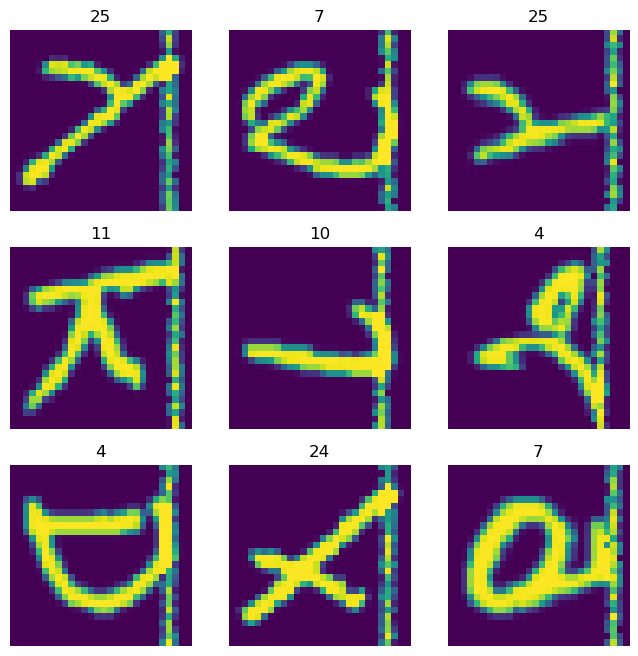

In [5]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.models import Sequential  # Model type to be used

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation # Types of layers to be used in our model
from tensorflow.keras.utils import to_categorical              # NumPy related tools

# Data should be located in a folder called EMNIST
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def add_to_255(a, b):
    "Return a+b to a max value of 255"
    if a + b > 255:
        return 255
    else:
        return a + b

v_add_to_255 = np.vectorize(add_to_255)

def noisy_line(img, label):
    """Adds background noise and a vertical line on the right edge to match data"""
    rng = np.random.default_rng()
    line = np.zeros((28,28,1), dtype=np.uint8)
    c = rng.integers(22, high=25, size=1)[0]
    line[:,c] = 127
    line[:,c+1] = 255
    line[:,c+2] = 127
    noise = rng.integers(0, high=128,size=(28,3,1))
    line[:,c:c+3] = line[:,c:c+3] - noise
    img = v_add_to_255(img, line)
    #img = np.clip(img, 0, 255)
    return img, label

z = np.zeros((28,28, 1), dtype=np.uint8)
print("noisy_line output shape", noisy_line(z, 20)[0].shape)

img_shape = ds_train.element_spec[0].shape
label_shape = ds_train.element_spec[1].shape
print("original image shape", img_shape)
print("original label shape", label_shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    img, lbl = noisy_line(image.numpy(), label.numpy())
    #img, lbl = image, label
    plt.imshow(img)
    plt.title(str(int(lbl)))
    plt.axis("off")


In [12]:
ds_train = ds_train.map(
  lambda img, label: tf.numpy_function(func=noisy_line, inp=[img, label], Tout=(tf.uint8, tf.int64)),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=False)
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
#ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [13]:



ds_test = ds_test.map(
  lambda img, label: tf.numpy_function(func=noisy_line, inp=[img, label], Tout=(tf.uint8, tf.int64)),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=False)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

print("dataset element_spec", ds_train.element_spec)

model = tf.keras.Sequential([
  tf.keras.Input(shape=(28,28), name='input'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(37)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)


dataset element_spec (TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 37)                4773      
                                                                 
Total params: 105253 (411.14 KB)
Trainable params: 105253 (411.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6
694/694 [==============================] - 64s 92ms/step - loss: 1.1201 - sparse_categorical_accuracy: 0.6825 - val_loss: 0.8164 - v

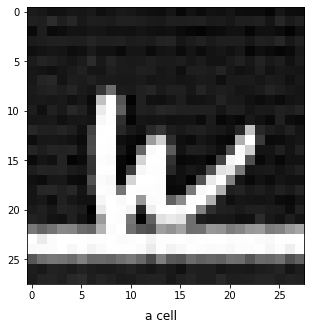

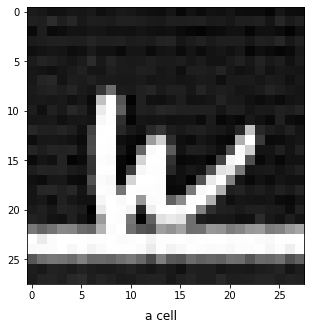

1/1 [==============================] - 0s 16ms/step
[23]


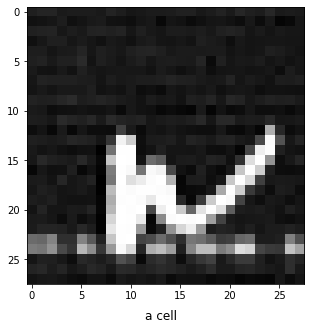

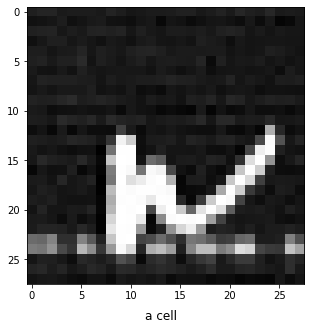

1/1 [==============================] - 0s 17ms/step
[23]


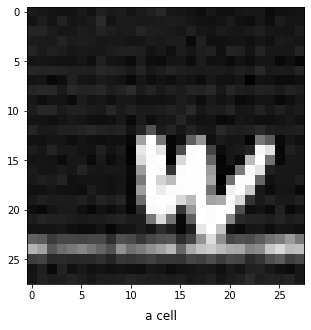

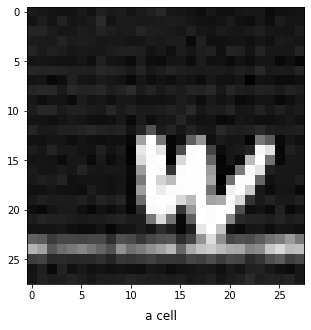

1/1 [==============================] - 0s 17ms/step
[23]


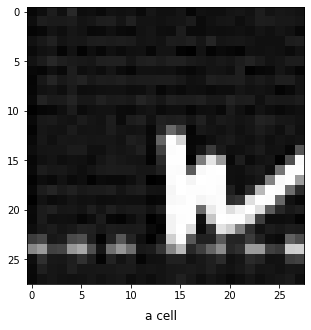

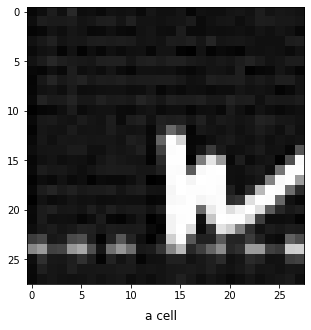

1/1 [==============================] - 0s 19ms/step
[17]


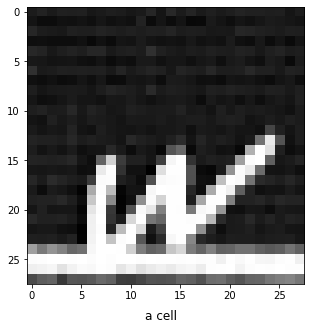

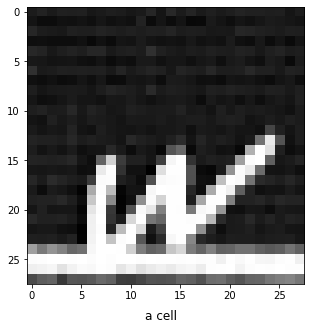

1/1 [==============================] - 0s 17ms/step
[23]


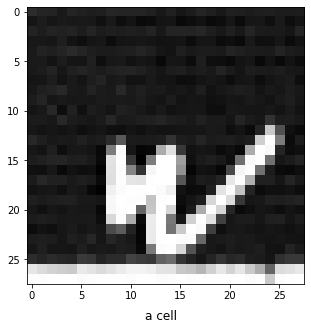

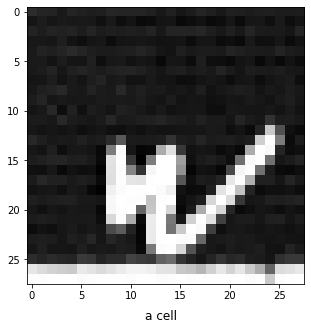

1/1 [==============================] - 0s 20ms/step
[23]


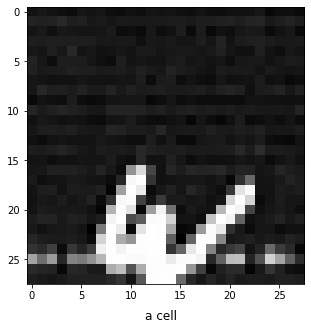

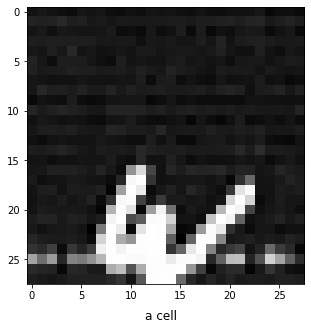

1/1 [==============================] - 0s 19ms/step
[2]


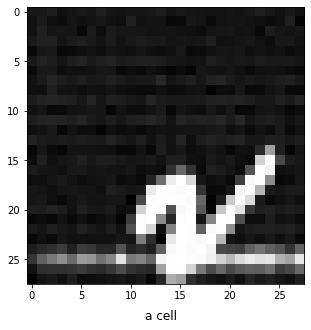

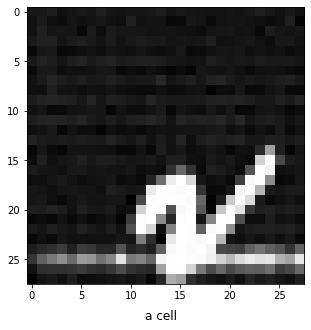

1/1 [==============================] - 0s 17ms/step
[17]


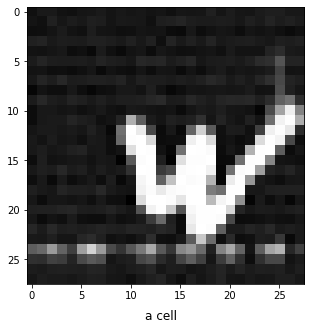

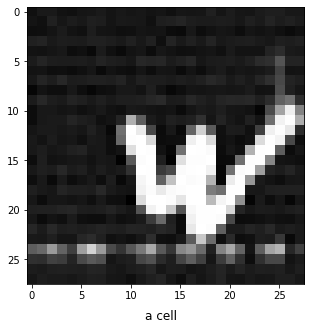

1/1 [==============================] - 0s 18ms/step
[23]


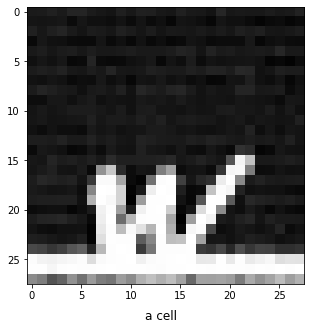

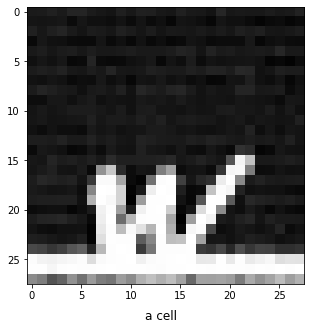

1/1 [==============================] - 0s 16ms/step
[23]


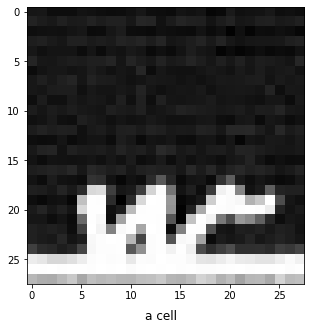

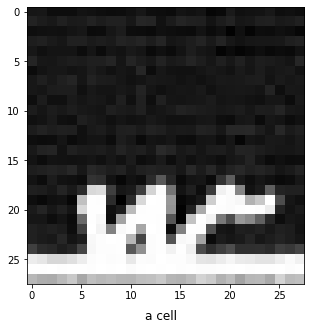

1/1 [==============================] - 0s 17ms/step
[23]


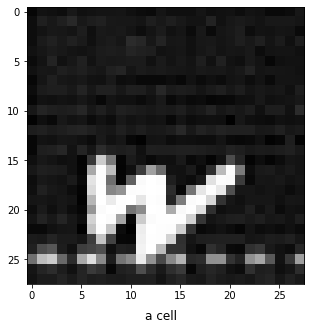

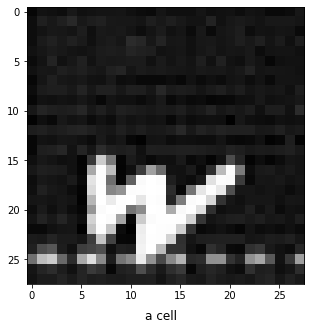

1/1 [==============================] - 0s 17ms/step
[23]


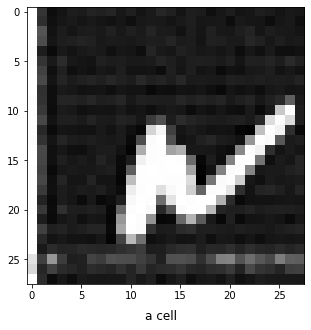

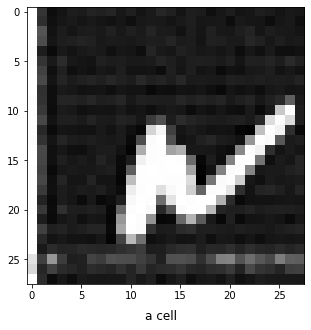

1/1 [==============================] - 0s 17ms/step
[23]


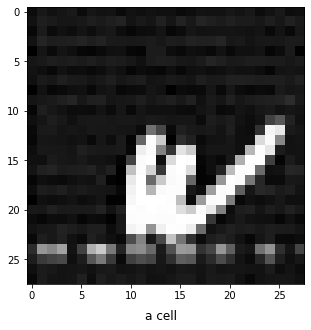

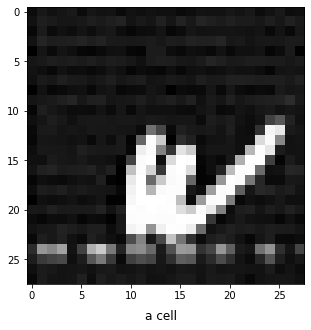

1/1 [==============================] - 0s 17ms/step
[23]


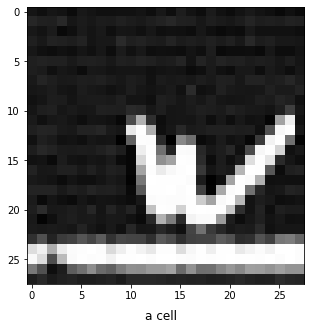

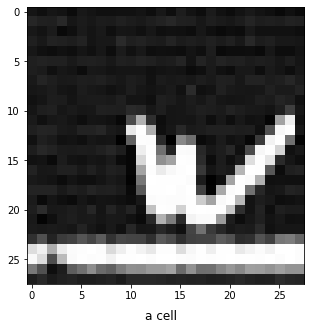

1/1 [==============================] - 0s 20ms/step
[23]


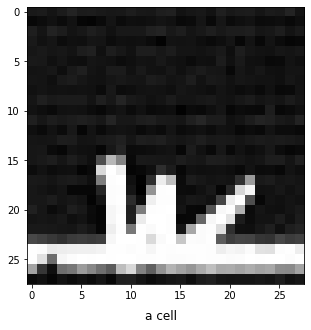

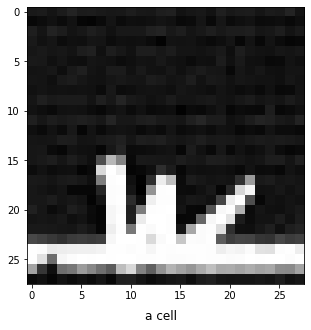

1/1 [==============================] - 0s 18ms/step
[23]


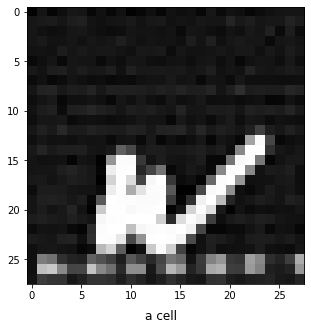

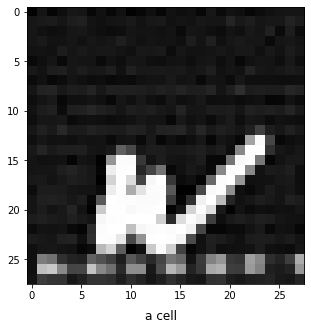

1/1 [==============================] - 0s 18ms/step
[23]


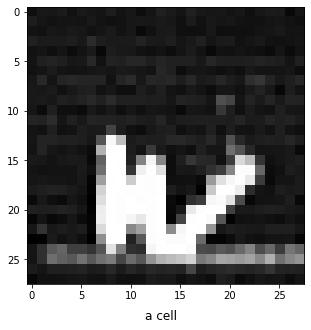

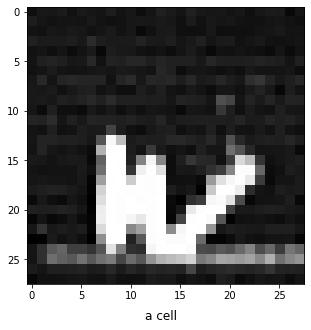

1/1 [==============================] - 0s 18ms/step
[23]


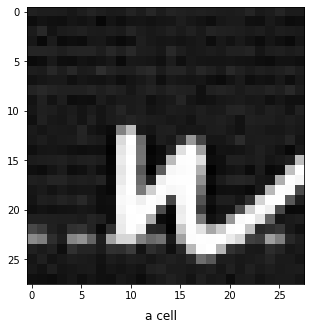

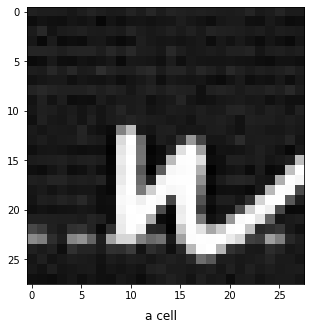

1/1 [==============================] - 0s 17ms/step
[23]


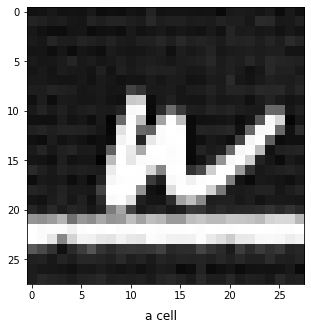

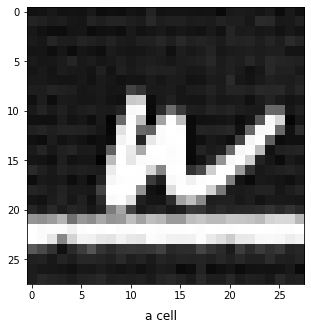

1/1 [==============================] - 0s 17ms/step
[23]


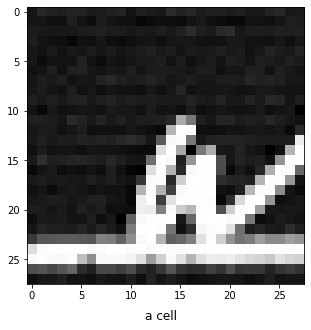

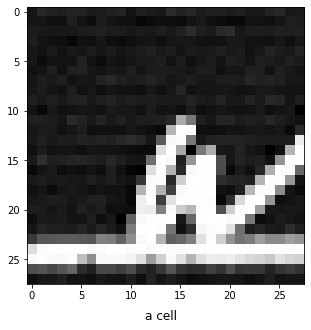

1/1 [==============================] - 0s 16ms/step
[23]


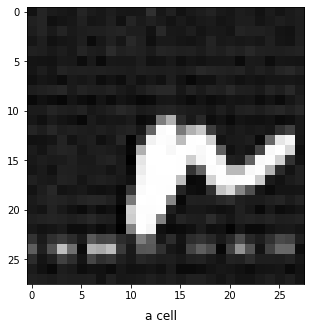

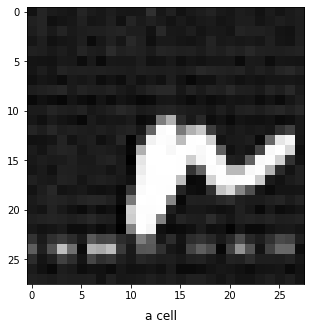

1/1 [==============================] - 0s 18ms/step
[23]


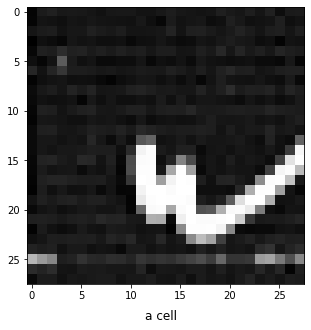

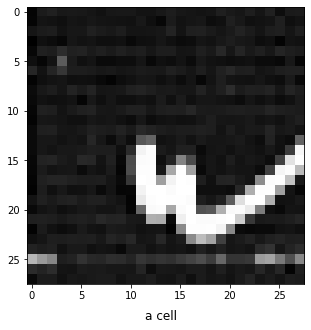

1/1 [==============================] - 0s 17ms/step
[23]


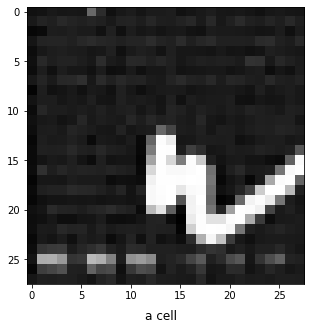

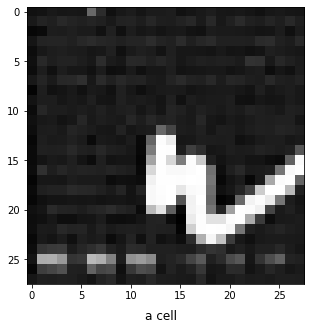

1/1 [==============================] - 0s 19ms/step
[23]


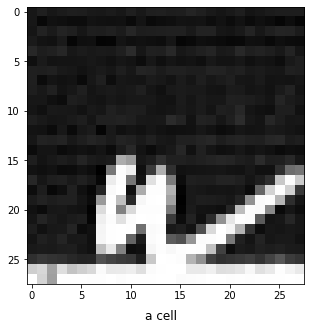

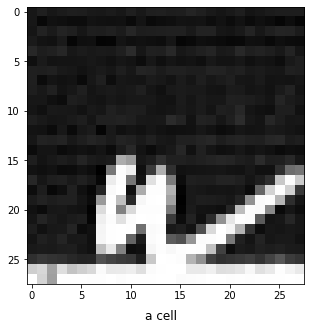

1/1 [==============================] - 0s 18ms/step
[23]


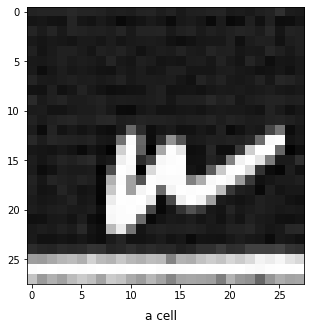

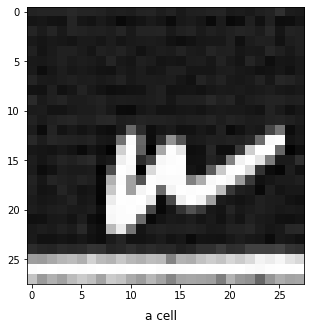

1/1 [==============================] - 0s 22ms/step
[23]


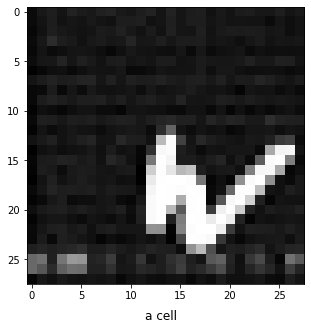

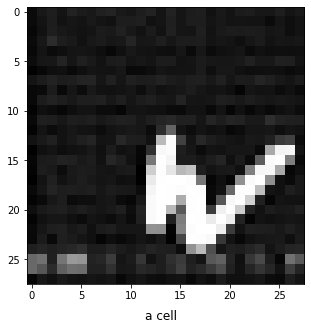

1/1 [==============================] - 0s 18ms/step
[23]


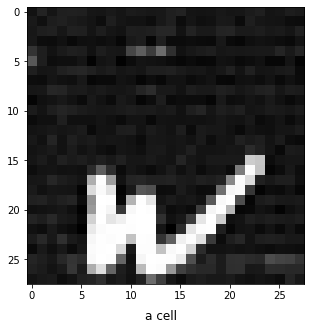

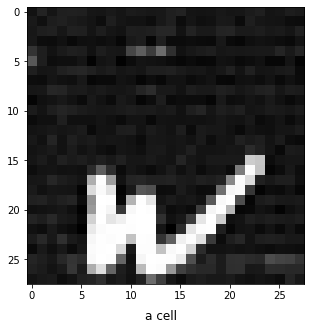

1/1 [==============================] - 0s 19ms/step
[2]


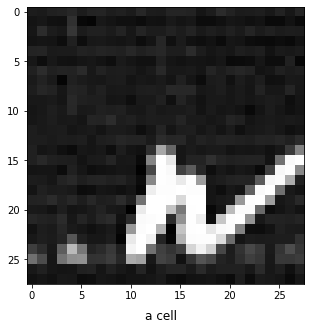

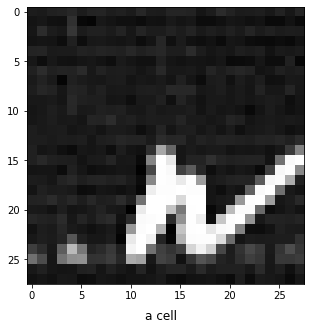

1/1 [==============================] - 0s 16ms/step
[23]


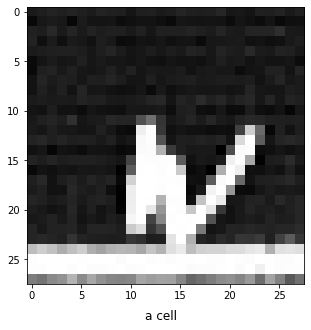

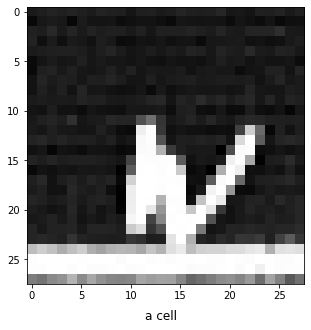

1/1 [==============================] - 0s 20ms/step
[23]


In [5]:
with open("segmentation.py") as f:
    code = f.read()
exec(code)
import glob
import re
import cv2

def run(path, page_range=(2, 16), debug=False):
    for f in sorted(glob.glob(f'{path}/*')):
        pagestr = re.search(r'-(\d+).jpeg', f).group(1)
        if int(pagestr) not in range(page_range[0], page_range[1]):
            continue
        image = cv2.imread(f)
        (adjusted_img, v_lines, h_lines) = extract(image, f, debug=debug)
        grayimage = cv2.cvtColor(adjusted_img,cv2.COLOR_BGR2GRAY)
        grayimage = 255 - grayimage
        #grayimage = cv2.threshold(grayimage, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
        demo_h_offset = v_lines[11]  # the demographic column starts the the 12th vertical line
        demo_width = v_lines[12] - demo_h_offset  # width calculation
        # Open CV rectangles calculation for each demographic cell
        demographic_cells = \
          [ (demo_h_offset, h_lines[i], demo_width, int(h_lines[i+1]-h_lines[i])) for i in range(3, len(h_lines)-1)]
        for i in range(3, len(h_lines)-1):
            cell_img = grayimage[h_lines[i]+5:h_lines[i+1]+5, v_lines[11]:v_lines[12]]
            M = cv2.moments(cell_img)
            X = int(M["m10"] / M["m00"])
            Y = int(M["m01"] / M["m00"])
            x1 = min(max(0, X-13), cell_img.shape[0] - 28)
            y1 = min(max(0, Y-13), cell_img.shape[1] - 28)
            cell = cell_img[x1:x1+28, y1:y1+28]
            view(cell, "a cell")
            tensor, noop = normalize_img(cell.T, 0)  # Note the transpose to match training set.
            view(cell, "a cell")
            result = model.predict(np.expand_dims(tensor, 0))
            classes_x=np.argmax(result,axis=1)
            print(classes_x)
        break
        # centroid/moment math is cutting off left side of some Ws..
        # Maybe just resize the whole cell image
        # TODO extract cell image and resize to 28x28 tensor image
        # TODO flip image appropriately for EMNIST
        # TODO test some image recognitions
        # TODO add matching "noise" to EMNIST?


run('pages', page_range=(14,16))

In [9]:
# Create the model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28,28, 1)),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(128, (3, 3), activation="relu", padding="valid"),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(26, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

2023-05-25 16:25:55.176863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


When I tested this code, I got mixed results - it wasn't always able to detect a W. I tried increasing the number of epochs the training model went through but I don't think it made a significant difference.

In [10]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
model.fit(np_images_2d, np_labels, epochs=7, validation_split=0.2)

# Save the model
model.save("model.h5")

Epoch 1/7
3120/3120 [==============================] - 39s 12ms/step - loss: 0.4593 - accuracy: 0.8525 - val_loss: 0.2708 - val_accuracy: 0.9119
Epoch 2/7
3120/3120 [==============================] - 40s 13ms/step - loss: 0.2224 - accuracy: 0.9249 - val_loss: 0.2162 - val_accuracy: 0.9276
Epoch 3/7
3120/3120 [==============================] - 38s 12ms/step - loss: 0.1852 - accuracy: 0.9356 - val_loss: 0.2024 - val_accuracy: 0.9333
Epoch 4/7
3120/3120 [==============================] - 40s 13ms/step - loss: 0.1614 - accuracy: 0.9422 - val_loss: 0.2112 - val_accuracy: 0.9319
Epoch 5/7
3120/3120 [==============================] - 37s 12ms/step - loss: 0.1446 - accuracy: 0.9474 - val_loss: 0.2046 - val_accuracy: 0.9332
Epoch 6/7
3120/3120 [==============================] - 41s 13ms/step - loss: 0.1315 - accuracy: 0.9514 - val_loss: 0.1889 - val_accuracy: 0.9377
Epoch 7/7
3120/3120 [==============================] - 38s 12ms/step - loss: 0.1175 - accuracy: 0.9559 - val_loss: 0.2004 - val_ac

In [11]:
# Test the model on the test dataset
metrics = model.evaluate(np_test_images_2d, np_test_labels, verbose=2)

650/650 - 3s - loss: 0.2042 - accuracy: 0.9358 - 3s/epoch - 4ms/step


Hebah's comment: this code gave me an error so I tried to do it a different way.

In [12]:
# Custom images test
import cv2
#from google.colab.patches import cv2_imshow
img = cv2.imread(r'w.jpg')
img_copy = img.copy()
img = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
img = cv2.transpose(img)
# img_final = cv2.resize(img_gray, (28,28))
img = np.subtract(255, img)
img_final = np.divide(img, 255)
img_final = np.reshape(img_final, (1,28,28,1))
#img_final = np.transpose(img_final)

print(model.predict(img_final))
img_pred = chr(np.argmax(model.predict(img_final))+65)

plt.imshow(img, cmap="Greys")
plt.xlabel("Prediction: "+ img_pred)
plt.show()

ValueError: cannot reshape array of size 4698 into shape (1,28,28,1)

Hebah's comment: I used this code to test out images using the W detection - I know previously Greg realized that the images needed to be rotated 90 degrees to work correctly but I found that whether or not I rotated them it still didn't always give the correct prediction. I also tried to increase contrast and sharpen the image to see if it had any impact but I was still getting incorrect predictions.

938/938 [==============================] - 4s 4ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  4.1404966e-35 0.0000000e+00]
 [1.5022918e-21 3.5236265e-25 0.0000000e+00 ... 3.7306385e-29
  3.2488538e-14 6.0672221e-27]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
938/938 [==============================] - 4s 4ms/step


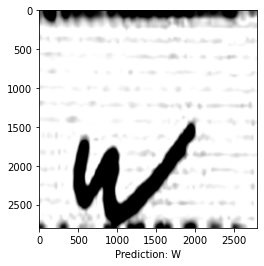

In [18]:
from PIL import Image, ImageFilter, ImageEnhance
size = 2800,2800

img = Image.open('w.jpg')
img2 = Image.open('row29.jpg')
img3 = Image.open('row30.jpg')

img = img.resize(size)
# img = img.rotate(90)  <-- I was unsure if this would make a difference
more_contrast = ImageEnhance.Contrast(img)
img = more_contrast.enhance(4)
img = img.filter(ImageFilter.SHARPEN)


img_final = np.asarray(img)
img_final = np.reshape(img_final, (-1, 28, 28, 1))

print(model.predict(img_final))
img_pred = chr(np.argmax(model.predict(img_final))+65)

plt.imshow(img, cmap="Greys")
plt.xlabel("Prediction: "+ img_pred)
plt.show()